<a href="https://colab.research.google.com/github/mimithecoconut/machine-learning-projects-20-21/blob/main/Shakespeare_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Team Smokey Bear
Team Members: Hannah Chen, Alexandra Lai, Shenyi Li, Felianne Teng


In [ ]:
import re
import random
import urllib.request
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

We first retrieve the input data from github. 

In [ ]:
url = "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/shakespeare.txt"
url_dict = "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/Syllable_dictionary.txt"
url_spenser = "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/spenser.txt"
file = urllib.request.urlopen(url)
file_spenser = urllib.request.urlopen(url_spenser)
file_dict = urllib.request.urlopen(url_dict)

For the Hidden Markov Model, we used the solution code from Problem Set 6. 

In [ ]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state. 
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    Output sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # Calculate initial prefixes and probabilities.
        for curr in range(self.L):
            probs[1][curr] = self.A_start[curr] * self.O[curr][x[0]]
            seqs[1][curr] = str(curr)

        # Calculate best prefixes and probabilities throughout sequence.
        for t in range(2, M + 1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                max_prob = float("-inf")
                max_prefix = ''

                # Iterate over all possible previous states to find one
                # that would maximize the probability of the current state.
                for prev in range(self.L):
                    curr_prob = probs[t - 1][prev] \
                                * self.A[prev][curr] \
                                * self.O[curr][x[t - 1]]

                    # Continually update max probability and prefix.
                    if curr_prob >= max_prob:
                        max_prob = curr_prob
                        max_prefix = seqs[t - 1][prev]

                # Store the max probability and prefix.
                probs[t][curr] = max_prob
                seqs[t][curr] = max_prefix + str(curr)

        # Find the index of the max probability of a sequence ending in x^M
        # and the corresponding output sequence.
        max_i = max(enumerate(probs[-1]), key=lambda x: x[1])[0]
        max_seq = seqs[-1][max_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        # print(len(alphas))
        # print(len(alphas[0]))
        # print(len(self.O))
        # print(len(self.O[0]))
        # Note that alpha_j(0) is already correct for all j's.
        # Calculate alpha_j(1) for all j's.
        for curr in range(self.L):
            alphas[1][curr] = self.A_start[curr] * self.O[curr][x[0]]

        # Calculate alphas throughout sequence.
        for t in range(1, M):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible previous states to accumulate
                # the probabilities of all paths from the start state to
                # the current state.
                for prev in range(self.L):
                    # print(str(t) +" " + str(prev) + " " + str(curr) + " " + str(x[t]))
                  
                
                    prob += alphas[t][prev] \
                            * self.A[prev][curr] \
                            * self.O[curr][x[t]]

                # Store the accumulated probability.
                alphas[t + 1][curr] = prob

            if normalize:
                norm = sum(alphas[t + 1])
                for curr in range(self.L):
                    alphas[t + 1][curr] /= norm

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize initial betas.
        for curr in range(self.L):
            betas[-1][curr] = 1

        # Calculate betas throughout sequence.
        for t in range(-1, -M - 1, -1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible next states to accumulate
                # the probabilities of all paths from the end state to
                # the current state.
                for nxt in range(self.L):
                    if t == -M:
                        prob += betas[t][nxt] \
                                * self.A_start[nxt] \
                                * self.O[nxt][x[t]]

                    else:
                        prob += betas[t][nxt] \
                                * self.A[curr][nxt] \
                                * self.O[nxt][x[t]]

                # Store the accumulated probability.
                betas[t - 1][curr] = prob

            if normalize:
                norm = sum(betas[t - 1])
                for curr in range(self.L):
                    betas[t - 1][curr] /= norm

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for curr in range(self.L):
            for nxt in range(self.L):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M - 1) \
                                if y[i] == curr and y[i + 1] == nxt])
                    den += len([1 for i in range(M - 1) if y[i] == curr])

                self.A[curr][nxt] = num / den

        # Calculate each element of O using the M-step formulas.
        for curr in range(self.L):
            for xt in range(self.D):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M) \
                                if y[i] == curr and x[i] == xt])
                    den += len([1 for i in range(M) if y[i] == curr])

                self.O[curr][xt] = num / den


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.
            N_iters:    The number of iterations to train on.
        '''

        # Note that a comment starting with 'E' refers to the fact that
        # the code under the comment is part of the E-step.

        # Similarly, a comment starting with 'M' refers to the fact that
        # the code under the comment is part of the M-step.

        for iteration in range(1, N_iters + 1):
            if iteration % 10 == 0:
                print("Iteration: " + str(iteration))

            # Numerator and denominator for the update terms of A and O.
            A_num = [[0. for i in range(self.L)] for j in range(self.L)]
            O_num = [[0. for i in range(self.D)] for j in range(self.L)]
            A_den = [0. for i in range(self.L)]
            O_den = [0. for i in range(self.L)]

            # For each input sequence:
            for x in X:
                M = len(x)
                # Compute the alpha and beta probability vectors.
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)

                # E: Update the expected observation probabilities for a
                # given (x, y).
                # The i^th index is P(y^t = i, x).
                for t in range(1, M + 1):
                    P_curr = [0. for _ in range(self.L)]
                    
                    for curr in range(self.L):
                        P_curr[curr] = alphas[t][curr] * betas[t][curr]

                    # Normalize the probabilities.
                    norm = sum(P_curr)
                    for curr in range(len(P_curr)):
                        P_curr[curr] /= norm

                    for curr in range(self.L):
                        if t != M:
                            A_den[curr] += P_curr[curr]
                        O_den[curr] += P_curr[curr]
                        O_num[curr][x[t - 1]] += P_curr[curr]

                # E: Update the expectedP(y^j = a, y^j+1 = b, x) for given (x, y)
                for t in range(1, M):
                    P_curr_nxt = [[0. for _ in range(self.L)] for _ in range(self.L)]

                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] = alphas[t][curr] \
                                                    * self.A[curr][nxt] \
                                                    * self.O[nxt][x[t]] \
                                                    * betas[t + 1][nxt]

                    # Normalize:
                    norm = 0
                    for lst in P_curr_nxt:
                        norm += sum(lst)
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] /= norm

                    # Update A_num
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            A_num[curr][nxt] += P_curr_nxt[curr][nxt]

            for curr in range(self.L):
                for nxt in range(self.L):
                    self.A[curr][nxt] = A_num[curr][nxt] / A_den[curr]

            for curr in range(self.L):
                for xt in range(self.D):
                    self.O[curr][xt] = O_num[curr][xt] / O_den[curr]

    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        emission = []
        state = random.choice(range(self.L))
        states = []

        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= self.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= self.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the output sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(0) gives the probability of the output sequence. Summing
        # this over all states and then normalizing gives the total
        # probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum([betas[1][k] * self.A_start[k] * self.O[k][x[0]] \
            for k in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrices A and O.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM


def unsupervised_HMM(X, n_states, N_iters,rng=np.random.RandomState(1)):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrices A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

## HMM without Rhyme 

We created a dictionary that corresponded each word with the number of syllables in the word. 

In [ ]:
syllable_dict = {}
id_dict = {}
for line in file_dict:
  line = line.decode("utf-8").strip()
  line = line.split(" ")
 
  # Handle the words with E denotation 
  if len(line) == 3:
    if ('E' in line[1]):
      syllable_dict[line[0]] = int(line[2])
    else:
      syllable_dict[line[0]] = int(line[1])
  if len(line) == 2:
    syllable_dict[line[0]] = int(line[1])

In [ ]:
word_ids = {}
ids_lst = []
id_count = 0
reverse_word_ids = {}

First, we read in the words from Shakespeare's sonnets and pre-processed the data. 

In [ ]:
for line in file:
  line = line.decode("utf-8").strip()
  # Ignore the lines that denote the number sonnet
  if len(line) > 3:
    # Remove all punctuation and convert everything to lowercase
    line = re.sub(r"[^\w\d'\s\-]+",'', line).lower()
    word_lst = line.split(" ")
    id_lst = []

    # Assign IDs to each word 
    for i in range(len(word_lst)):
      word = word_lst[i].lower()
      if word not in word_ids:
        word_ids[word] = id_count
        reverse_word_ids[id_count] = word
        id_count += 1
      id_lst.append(word_ids[word])
    ids_lst.append(id_lst)
print(ids_lst)
print(word_ids)

We also read in the words found in Spenser's poems and pass them to the HMM. 

In [ ]:
for line in file_spenser:
  line = line.decode("utf-8").strip()
  # Ignore the lines that denote the number sonnet
  if len(line) > 3:
    # Remove all punctuation and convert everything to lowercase
    line = re.sub(r"[^\w\d'\s\-]+",'', line).lower()
    word_lst = line.split(" ")
    id_lst = []

    # Assign IDs to each word 
    for i in range(len(word_lst)):
      word = word_lst[i].lower()
      if word not in word_ids:
        word_ids[word] = id_count
        reverse_word_ids[id_count] = word
        id_count += 1
      id_lst.append(word_ids[word])
    ids_lst.append(id_lst)
print(ids_lst)
print(word_ids)

In [ ]:
HMM = unsupervised_HMM(ids_lst, 10, 100)
emissions, states = HMM.generate_emission(200)


Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100


In [ ]:
# print(HMM.generate_emission(10))

line_count = 10
line_string = ""
num_lines = 0
capitalize_words = ["i", "o"]
for e in emissions: 
  word = reverse_word_ids[e]
  if word in syllable_dict:
    syllable = syllable_dict[word]
    if word in capitalize_words:
      word =word.capitalize()
    if line_count - syllable == 0:
      line_string += word
      num_lines += 1
      if (num_lines % 4 == 0 or num_lines == 14): 
        print(line_string + "." )
        print()
      else:
        print(line_string + ",")
      line_string = ""
      line_count = 10
    elif line_count - syllable > 0:
      if line_count == 10:
        word = word.capitalize()
      line_count -= syllable
      line_string += word + " "
      # print(line_string)
    
  if num_lines == 14:
    break
   
  



Me and can do thy rest and so not like,
Respects endure my one or know which head,
Doth his mak'st babe my meditation thy,
Him do thou thou was term for delayed the.

Horse one summer's and quicker was that own,
Fire do that self since motion great progress,
Can my the to to of are none love thou,
Thy thunder her in canst beshrew subsist.

Will triumph appeal praise young thy show make,
Wing love was a self rearward doth your a,
Glass greater beauty wit one my self-loving,
No to most of I unrespected is.

Thy soft evil then her not and in the,
Up straight to my censures tresses the a.



## HMM with Rhyme

In [ ]:
sonnets = []
sonnet = []
file = urllib.request.urlopen(url)  
for line in file:
  line = line.decode("utf-8").strip()
  line = re.sub(r"[^\w\d'\s\-]+",'', line).lower()
  if len(line) <= 3:
    if len(sonnet) == 14:
      sonnets.append(sonnet)
    sonnet = []
    continue
  sonnet.append(line)
print(sonnets)

We create a function add_rhyming that takes in two words, first and second, and by default, found_set = None. The function adds two words to a set in the rhyming dictionary and creates a new set if necessary. 

In [ ]:
rhyming_dict = []
def add_rhyming(first, second, found_set):
  for rhyming_set in rhyming_dict:
    if first in rhyming_set:
      if found_set == None:
        rhyming_set.add(second)
        found_set = rhyming_set
      else:
        rhyming_dict.remove(rhyming_set)
        found_set.update(rhyming_set)
        break
    elif second in rhyming_set:
      if found_set == None:
        rhyming_set.add(first)
        found_set = rhyming_set
      else:
        rhyming_dict.remove(rhyming_set)
        found_set.update(rhyming_set)
        break
  if found_set == None:
    rhyming_dict.append({first, second})

The first_lines array contains the lines of the sonnet that have a corresponding rhyming line after. We remove sets in the rhyming dictionary that have only 1 rhyming element (i.e. the word does not have a word that rhymes with it). 

In [ ]:
first_lines = [0, 1, 4, 5, 8, 9]
for sonnet in sonnets:
  for i in first_lines:
    first = sonnet[i].split(" ")[-1]
    second = sonnet[i + 2].split(" ")[-1]
    add_rhyming(first, second, None)
  add_rhyming(sonnet[12].split(" ")[-1], sonnet[13].split(" ")[-1], None)

for rhyming_set in rhyming_dict:
  if len(rhyming_set) == 1:
    rhyming_dict.remove(rhyming_set)

for word in rhyming_dict[0].copy():
    if len(word) == 1:
      rhyming_dict[0].remove(word)



We also have some helper functions for generating the rhyming scheme. generate_rhyming_word takes in a word and a line of the poem, and modifies the last word of the line to rhyme with the provided word. has_rhyming_word checks if the word is in the rhyming dictionary. update_rhyming_word takes in the last_word and modifies the last word if the last word is not initially in the rhyming dictionary.

In [ ]:
# rhyming helper functions

def generate_rhyming_word(word, line_string):
  line_string_split = line_string.split(" ")
  for rhyming_set in rhyming_dict:
    result = word
    if word in rhyming_set:
      while (result == word):
        result = random.choice(tuple(rhyming_set))
      line_string_split[-1] = result
      # print(line_string_split)
      return ' '.join(word for word in line_string_split)

def has_rhyming_word(word):
  for rhyming_set in rhyming_dict:
    if word in rhyming_set:
      return True
  return False

def update_last_word(line_string):
  line_string_split = line_string.split(" ")
  rhyming_set = random.choice(rhyming_dict)
  rhyming_word = random.choice(tuple(rhyming_set))
  line_string_split[-1] = rhyming_word
  return ' '.join(word for word in line_string_split)

In [ ]:
emissions, states = HMM.generate_emission(200)

In [ ]:
# generate poem with rhyme

last_words = []
line_count = 10
line_string = ""
num_lines = 0
capitalize_words = ["i", "o"]
for e in emissions: 
  word = reverse_word_ids[e]
  if word in syllable_dict:
    syllable = syllable_dict[word]
    if word in capitalize_words:
      word =word.capitalize()
    if line_count - syllable == 0:
      line_string += word
      num_lines += 1
      if (num_lines % 4 == 0 or num_lines == 14): 
        if num_lines % 4 == 0:
          line_string = generate_rhyming_word(last_words[-2], line_string)
        if num_lines == 14:
          line_string = generate_rhyming_word(last_words[-1], line_string)
        print(line_string + "." )
        print()
        last_words.append(line_string.split(" ")[-1])
      else:
        # print(num_lines)
        if num_lines % 4 != 3:
          if not has_rhyming_word(line_string.split(" ")[-1]):
            line_string = update_last_word(line_string)
        if num_lines % 4 == 3:
          line_string = generate_rhyming_word(last_words[-2], line_string)
        # print(num_lines)
        print(line_string + ",")
        last_words.append(line_string.split(" ")[-1])
      line_string = ""
      line_count = 10
    elif line_count - syllable > 0:
      if line_count == 10:
        word = word.capitalize()
      line_count -= syllable
      line_string += word + " "
      # print(line_string)
    
  if num_lines == 14:
    break



And divine the gently in set the prime,
Course heavy mourners your thee and is write,
The welcome thee and day can which wrong time,
Fire pluck hanging know is I by fight.

With because part thy rest of increase extreme,
Must my glory worth not be son and by,
Then releasing thy sins to her face dream,
We yet hath pride love's may would batt'ring die.

Attaint with sour thoughts for my memory,
The mine own for her nor so doth his bright,
Mark plead with resemble I with and decree,
Looks in frame own is bereft that you write.

More thee vile other wilt should the stars more,
Queen 'greeing complain annoy lord shore.



## Haiku

In [ ]:
emissions, states = HMM.generate_emission(25)

In [ ]:
# stores the syllable for each line
line_counts = [5, 7, 5] 
line_string = ""
num_lines = 0
capitalize_words = ["i", "o"]
for e in emissions: 
  word = reverse_word_ids[e]
  if word in syllable_dict:
    syllable = syllable_dict[word]
    if word in capitalize_words:
      word =word.capitalize()
 
    if line_counts[num_lines] - syllable == 0:
      line_string += word
      print(line_string)
      print()
      num_lines += 1
      line_string = ""
      if num_lines == 2:
        line_count = 7
      elif num_lines == 3:
        line_count = 5
    elif line_count - syllable > 0:
      num = line_counts[num_lines] - syllable
      line_counts[num_lines] = num
      line_string += word + " "

  if num_lines == 3:
    break

life when not king hast

when play nor bosom devised

decayed the saint by



## Petrarchan Sonnet 

In [ ]:
emissions, states = HMM.generate_emission(1000)

In [ ]:
# check to see that word has at least 4 rhyming words
def has_rhyming_word_4(word):
  for rhyming_set in rhyming_dict:
    if word in rhyming_set and len(rhyming_set) >= 4:
      return True
  return False

In [ ]:
last_words = []
line_count = 10
# store the line numbers for the rhymes 
a_lines = [4, 5, 8]
b_lines = [3, 6, 7]
c_lines = [11, 13]
d_lines = [12, 14]
line_string = ""
num_lines = 0
capitalize_words = ["i", "o"]
for e in emissions: 
  word = reverse_word_ids[e]
  # make sure word has corresponding syllable and at least 4 rhyming words 
  if word in syllable_dict and has_rhyming_word_4(word):
    syllable = syllable_dict[word]
    if word in capitalize_words:
      word =word.capitalize()
    if line_count - syllable == 0:
      line_string += word
      num_lines += 1
      if num_lines in a_lines:
          line_string = generate_rhyming_word(last_words[0], line_string)
      if num_lines in b_lines:
        line_string = generate_rhyming_word(last_words[1], line_string)
      if num_lines in c_lines:
        line_string = generate_rhyming_word(last_words[2], line_string)
      if num_lines in d_lines:
        line_string = generate_rhyming_word(last_words[3], line_string)
      if (num_lines % 4 == 0 or num_lines == 14): 
        print(line_string + ".")
        if (num_lines % 8 == 0):
          print()
      else:
        print(line_string + ",")
      if (num_lines == 1 or num_lines == 2 or num_lines == 9 or num_lines == 10):
        last_words.append(line_string.split(" ")[-1])
      line_string = ""
      line_count = 10
    elif line_count - syllable > 0:
      if line_count == 10:
        word = word.capitalize()
      line_count -= syllable
      line_string += word + " "
    
  if num_lines == 14:
    break

Fair thee light will are sing lost age it thee,
Upon see fight I by away fair by,
It one fiend day by knife why love it lie,
It pain it true prove are eyes bright lost fortify.
Me I made upon upon shame love majesty,
Best time say love thine ye show his love idolatry,
Were everywhere it is bold last are alchemy,
Bide sight love I me art go case me i.

Me be see prove is I rent I days not,
Day hold crime is by find time is his thee,
Part pen no guest this fight say fair fire forgot,
Book make you appear I on leisure free.
Again fly me will friend due gay rare plot,
Pain look wide make pen then those I on why.


## Limerick

In [ ]:
rhyming_dict2 = rhyming_dict.copy()
for rhyming_set in rhyming_dict2.copy():
  if len(rhyming_set) == 2:
    rhyming_dict2.remove(rhyming_set)

In [ ]:
# modified rhyming helper functions
def generate_rhyming_word2(word1, word2, line_string):
  line_string_split = line_string.split(" ")
  for rhyming_set in rhyming_dict2:
    result = word1
    if word1 in rhyming_set:
      while (result == word1 or result == word2):
        result = random.choice(tuple(rhyming_set))
      line_string_split[-1] = result
      # print(line_string_split)
      return ' '.join(word for word in line_string_split)

def has_rhyming_word2(word):
  for rhyming_set in rhyming_dict2:
    if word in rhyming_set:
      return True
  return False

def update_last_word2(line_string):
  line_string_split = line_string.split(" ")
  rhyming_set = random.choice(rhyming_dict2)
  rhyming_word = random.choice(tuple(rhyming_set))
  line_string_split[-1] = rhyming_word
  return ' '.join(word for word in line_string_split)

In [ ]:
# HMM = unsupervised_HMM(ids_lst, 10, 50)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50


In [ ]:
last_words = []
line_count = 10
line_string = ""
num_lines = 0
capitalize_words = ["i", "o"]
for e in emissions: 
  word = reverse_word_ids[e]
  if word in syllable_dict:
    syllable = syllable_dict[word]
    if word in capitalize_words:
      word =word.capitalize()
    if line_count - syllable == 0:
      line_string += word
      num_lines += 1
      if (num_lines == 5 or num_lines == 2): 
        if num_lines == 2:
          line_string = generate_rhyming_word(last_words[0], line_string)
        if num_lines == 5:
          line_string = generate_rhyming_word2(last_words[0], last_words[1], line_string)
        print(line_string + "." )
        print()
        last_words.append(line_string.split(" ")[-1])
      else:
        # print(num_lines)
        if num_lines == 1 or num_lines == 3:
          if not has_rhyming_word2(line_string.split(" ")[-1]):
            line_string = update_last_word2(line_string)
        if num_lines == 4:
          line_string = generate_rhyming_word(last_words[-1], line_string)
        # print(num_lines)
        print(line_string + ",")
        last_words.append(line_string.split(" ")[-1])
      line_string = ""
      line_count = 10
    elif line_count - syllable > 0:
      if line_count == 10:
        word = word.capitalize()
      line_count -= syllable
      line_string += word + " "
      # print(line_string)
    
  if num_lines == 5:
    break

Doth my dearest fair in things female none,
The slave than soon as their physic of on.

Light all of we golden will with and brow,
Cruel are and sing at thy constant mow,
Of lost my devised of to sweet age stone.



## Recurrent Neural Network



Here, we divide the training data into sequences of length 40. 

In [ ]:
file = urllib.request.urlopen(url)
sequences = []
next_char = []
seq_len = 40
text_block = ""

# Concatenate lines of file into one string
for line in file: 
  line = line.decode("utf-8").strip().lower()
  if len(line) > 3:
    text_block += line + "\n"

# Divides string into sequences of length seq_len
for ind in range(0, len(text_block) - seq_len):
  sequences.append(text_block[ind:ind+seq_len])
  next_char.append(text_block[ind+seq_len])

Next, we assign each unique character present in the dataset an ID, which corresponds to the index of the character in the prediction numpy array. We process each sequence such that the neural network is able to train on it. Each sequence is converted to a numpy array that has indices corresponding to the character indices. Each of these indices contains the frequency of the character in the sequence.

In [ ]:
# Finds unique characters present in data 
characters = set()
for seq in sequences:
    characters |= set(seq)
characters = sorted(list(characters))
char_id = {}
id = 0

# Assign each character an id
for c in characters: 
  char_id[c] = id
  id += 1
rev_char_id = {}
for key in char_id: 
  rev_char_id[char_id[key]] = key

# Converts the character sequences into numpy array
x = np.zeros((len(sequences), 40, len(characters)))
y = np.zeros((len(sequences), len(characters)))
for i in range(len(sequences)):
  seq = sequences[i]
  for j in range(len(sequences[i])):
    x[i, j, char_id[seq[j]]] += 1
  y[i, char_id[next_char[i]]] += 1

For the neural network model, we use a single LSTM layer with 200 units followed by a Softmax output layer. We use categorical cross entropy to measure loss. The model is trained over 20 epochs with a batch size of 128. 

In [ ]:
# Sets up the model
model = keras.Sequential(
    [
        keras.Input(shape=(seq_len, len(characters))),
        layers.LSTM(200),
        layers.Dense(len(characters), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
# Trains the model
epochs = 20
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)

732/732 [==============================] - 5s 6ms/step - loss: 1.0825


The following functions are used to generate a sonnet. The `sample` function takes in the temperature to control the variance of the prediction. The `generate_sonnet_nn` function uses the trained model to produce a poem with the given number of lines. The `format_sonnet` function takes in the sequence generated by `generate_sonnet_nn` and returns a formatted version of it, by adding proper spacing and capitalization.

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array 
    # source: https://keras.io/examples/generative/lstm_character_level_text_generation/
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def generate_sonnet_nn(seed, temp, num_lines):
  n_seed = seed[:]
  generated = ""
  curr_lines = 0
  while curr_lines < num_lines:
      # Converts current seed into prediction array 
      x_pred = np.zeros((1, 40, len(characters)))
      for i in range(len(n_seed)):
        x_pred[0, i, char_id[n_seed[i]]] += 1
      
      # Use model to predict next character in sequence
      preds = model.predict(x_pred, verbose=0)[0]
      next_index = sample(preds, temp)
      next_char = rev_char_id[next_index]

      # Increment the number of lines 
      if next_char == '\n':
        curr_lines += 1

      # Update next sequence to use for prediction 
      n_seed = n_seed[1:] + next_char
      generated += next_char
  return generated

In [ ]:
def format_sonnet(seq):
  # Divide sequence based on lines
  lines = seq.split("\n")
  capitalize_words = ["i", "o"]
  for i in range(len(lines)):
    # Capitalize first word in each line
    lines[i] = lines[i].capitalize()

    # Add spacing between quatrains
    if (i + 1) % 4 == 0 or i + 1 == 14:
      lines[i] += "\n"

    # Divide each line by words
    words = lines[i].split(" ")
    for j in range(len(words)):
      # Capitalize word if it is in the list of words to capitalize
      if words[j] in capitalize_words: 
        words[j] = words[j].upper()
    lines[i] = " ".join(words)
  return "\n".join(lines)

The following code prints the generated sonnets for temperature levels of 0.25, 0.75, and 1.5. 

In [ ]:
init = "shall i compare thee to a summer's day?\n"
for temp in [0.25, 0.75, 1.5]:
  print("Temperature: " + str(temp))
  seq = generate_sonnet_nn(init, temp, 14)
  print(format_sonnet(seq))

Temperature: 0.25
Who hath beauty of the world's eye and me,
That thou art the bounteous beauty shall bear,
And that thou art all thou that the thought,
Which have that which it was not beauty best,

The book of the dear love that thou art form and thee,
And that thou shalt be thy progured thy name:
But thou art as the world's field may still,
To make him the world's argument the fire,

And then the world with thee that which you
Doth my heart thou art brightness worth be still,
To make him the world with thee that thou dost love,
That thou art that shall for the world,

And then the strong her thought I see thee,
Who heaven thee that thou art that love thee,


Temperature: 0.75
Or whether shall not thou pride the pain.
You or me as a leagh an eansware thence.
Then delf remain of contraly,
And thou there both randows as his proove,

That that live to breeds to mine own still,
But that you desired fience of thine, here
Where I have I pride, when thou that all see,
Nam they did prove the

In [ ]:
# Visualization

########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize sparsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()



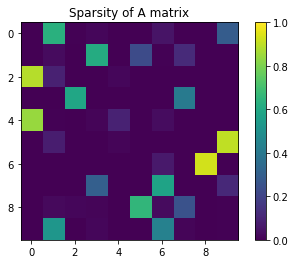

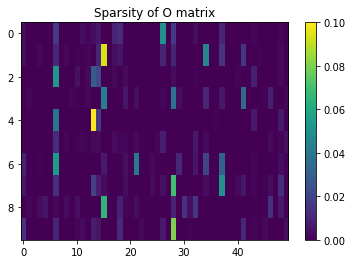

In [ ]:
visualize_sparsities(HMM, O_max_cols=50)

In [ ]:
for n in range(0, 10):
  O_matrix = np.array(HMM.O[n])
  ind = np.argpartition(O_matrix, -10)[-10:]
  words = ""
  print("State " + str(n) + ":")
  for i in ind:
    words += reverse_word_ids[i] + " "
  print(words)

State 0:
for to when she that is in i all thou 
State 1:
not your in my their be i thy it the 
State 2:
what so when or and as that but do which 
State 3:
him no her you love to thee me a the 
State 4:
so yet when o but for then if that and 
State 5:
in thou will heart and that i or is were 
State 6:
your that so his of my thy with her mine 
State 7:
sweet that doth is but to for in and with 
State 8:
fair it self own eyes which love her heart the 
State 9:
will from of do on not doth can in to 


In [ ]:
states_to_wordclouds(HMM, word_ids)